# Работа с некоторыми наборами параметров временных радов.

1.1 Некоторые определения

Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки

Таким образом, данные оказываются упорядочены относительно неслучайных моментов времени, и, значит, в отличие от случайных выборок, могут содержать в себе дополнительную информацию, которую мы постараемся извлечь. 

1.2 Движемся, сглаживаем и оцениваем

In [1]:
# импортируем нужные библиотеки

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
# Если каких то библиотек нет то устанавливаем их следующим образом
#!pip3 install statsmodels

В качестве примера для работы возьмем реальные данные по часовому онлайну игроков в одной из мобильных игрушек:

/home/al/Projects_My/examples_problem_solving_kaggl/working_with_time_series/datasets/hour_online.csv

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

init_notebook_mode(connected = True)

In [4]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

dataset = pd.read_csv('/home/al/Projects_My/examples_problem_solving_kaggl/working_with_time_series/datasets/hour_online.csv', 
                      index_col=['Time'], 
                      parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

1.2.1 Rolling window estimations - оценки скользящего окна

Начнем моделирование с наивного предположения — "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней. 

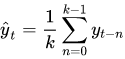

In [5]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Users, 24)

29858.333333333332

К сожалению, такой прогноз долгосрочным сделать не удастся — для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение — сглаживание исходного ряда для выявления трендов. В пандасе есть готовая реализация — DataFrame.rolling(window).mean(). Чем больше зададим ширину интервала — тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь с определением общих паттернов.

Для нашего ряда тренды и так вполне очевидны, но если сгладить по дням, становится лучше видна динамика онлайна по будням и выходным (выходные — время поиграть), а недельное сглаживание хорошо отражает общие изменения, связанные с резким ростом числа активных игроков в феврале и последующим снижением в марте.

In [6]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

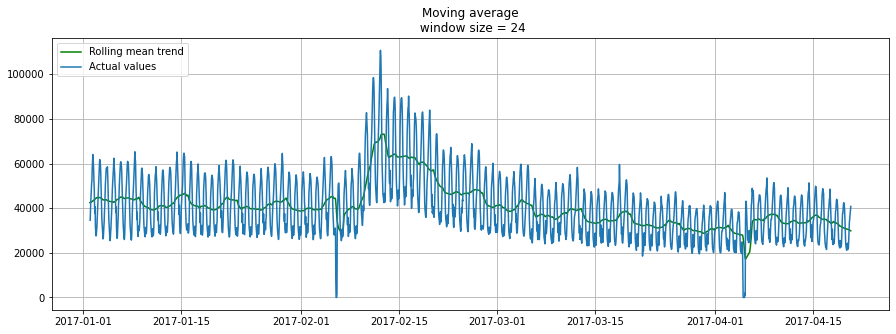

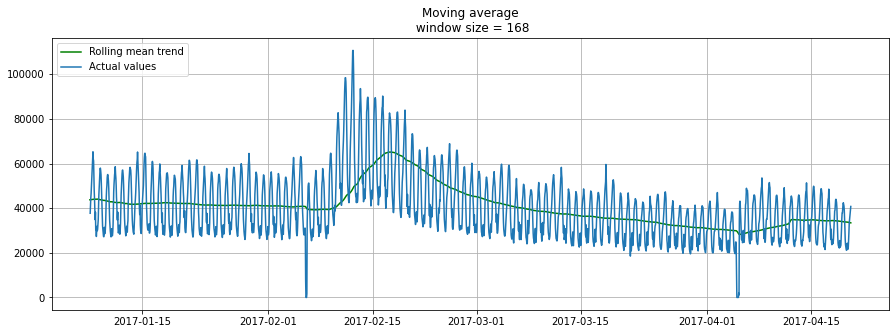

In [7]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 

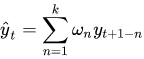

In [8]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

35967.55

Экспоненциальное сглаживание, модель Хольта-Винтерса

Простое экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений 
ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая 
веса по мере углубления в исторические данные. В этом нам поможет формула простого 
экспоненциального сглаживания:
    


Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции — каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.
    

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

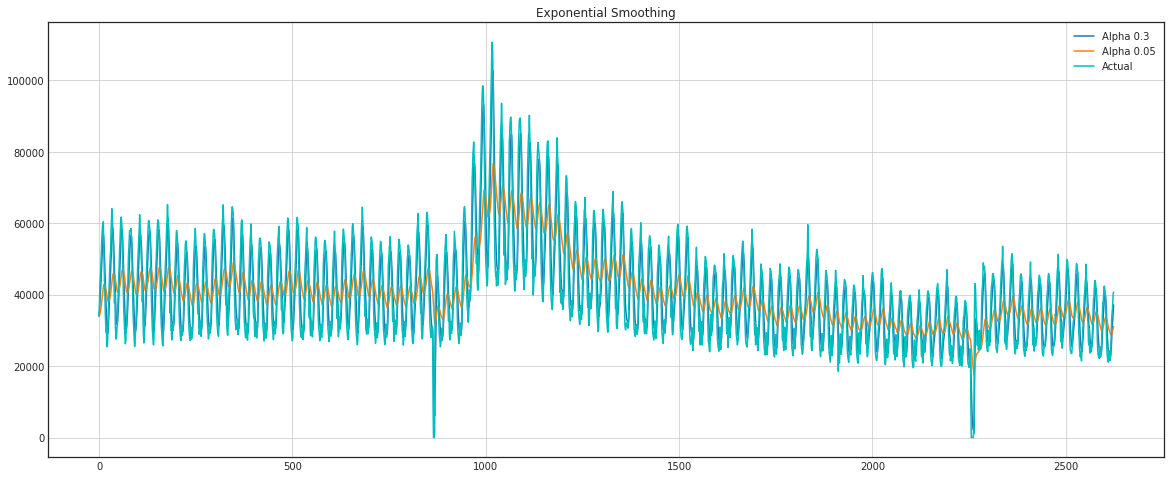

In [10]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

Теперь настраивать пришлось уже два параметра — $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй — за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. А о не ручном подборе параметров расскажу чуть ниже, сразу после тройного экспоненциального сглаживания.

3. Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты — сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью не обделён, что в нашем случае верно. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона — периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

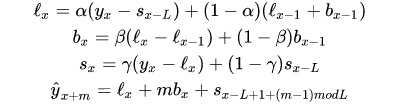


Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, то и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать здесь. Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать.

Ниже приведен код для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей — Чарльза Хольта и его студента Питера Винтерса.
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

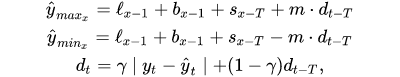


где $T$ — длина сезона, $d$ — предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть здесь - 
https://fedcsis.org/proceedings/2012/pliks/118.pdf


In [11]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

4. Кросс-валидация на временных рядах, подбор параметров

Перед тем, как построить модель, поговорим, наконец, о не ручной оценке параметров для моделей.

Ничего необычного здесь нет, по-прежнему сначала необходимо выбрать подходящуюю для данной задачи функцию потерь: RMSE, MAE, MAPE и др., которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и бодро опускаться в сторону глобального минимума ошибки.

Небольшая загвоздка возникает только в кросс-валидации. Проблема состоит в том, что временной ряд имеет, как ни парадоксально, временную структуру, и случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров, официального названия которому я так и не нашел, но на сайте CrossValidated - https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection, где можно найти ответы на всё, кроме главного вопроса Жизни, Вселенной и Всего Остального, предлагают название "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста — начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

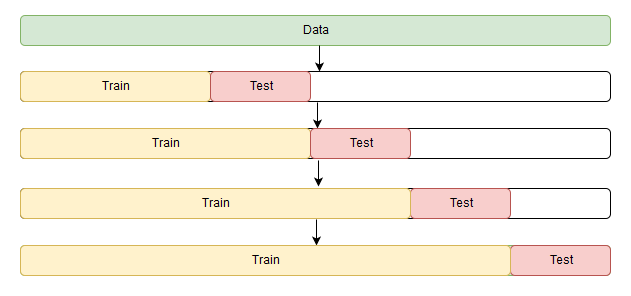


In [12]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

Значение длины сезона 24*7 возникло не случайно — в исходном ряде отчетливо видна дневная сезонность, 
(отсюда 24), и недельная — по будням ниже, на выходных — выше, (отсюда 7), суммарно сезонных компонент 
получится 24*7.

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на 
величину сглаживающих параметров — каждый из них может принимать значения от 0 до 1, поэтому для минимизации 
функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном 
случае — Truncated Newton conjugate gradient.

In [13]:
%%time
data = dataset.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006634267064344168 0.0 0.0467652042896729
CPU times: user 18.5 s, sys: 0 ns, total: 18.5 s
Wall time: 18.5 s


Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 5 дней вперёд (128 часов)

In [14]:
# Передаем оптимальные значения модели, 
data = dataset.Users
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

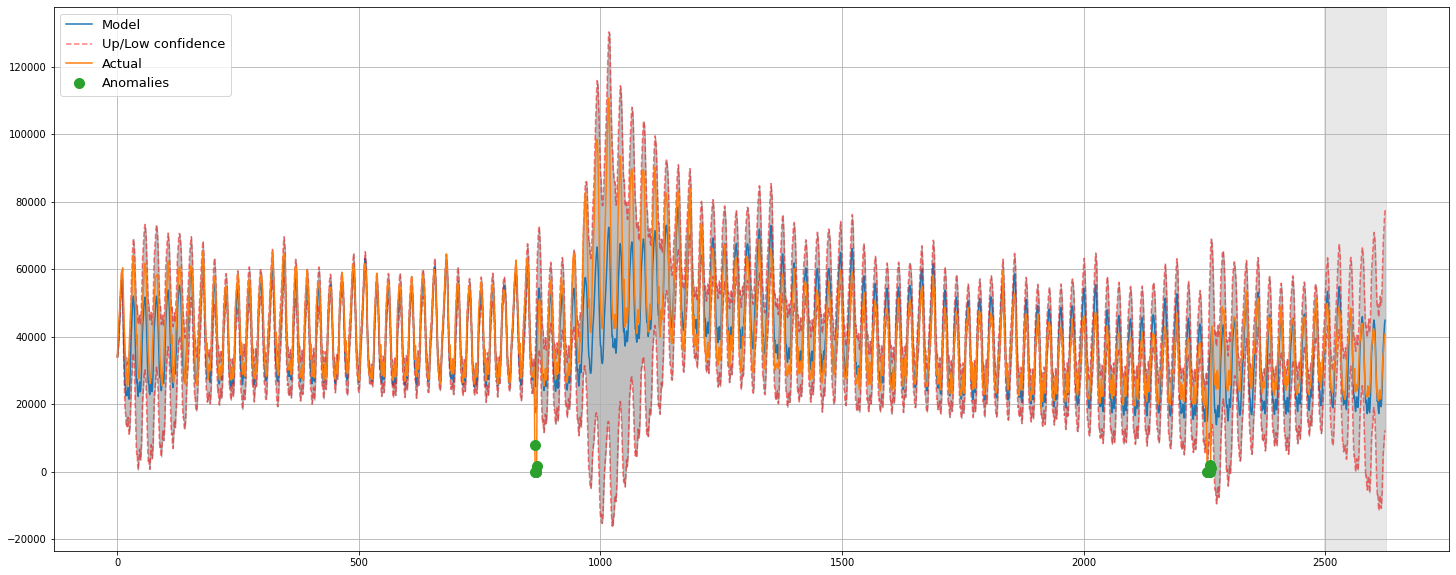

In [15]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

Судя по графику, модель неплохо описала исходный временной ряд, уловив недельную и дневную сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов. Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


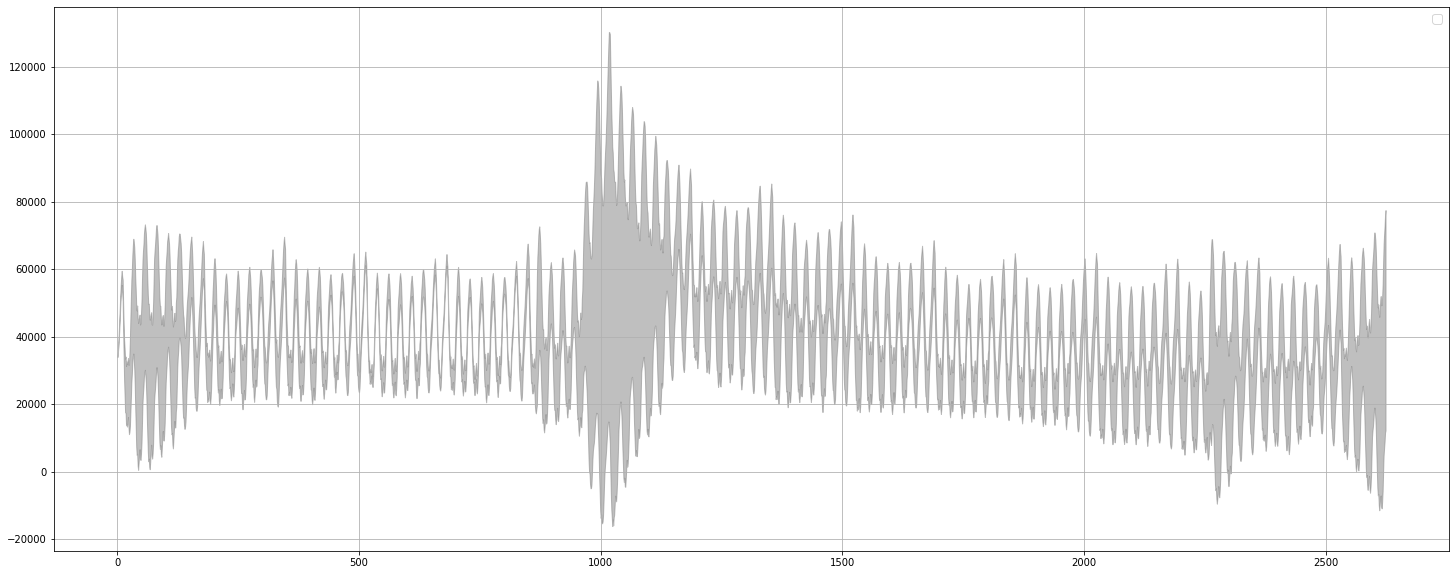

In [16]:
def plotHoltWinters2():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    #plt.plot(model.result, label = "Model")
    #plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    #plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    #plt.plot(data.values, label = "Actual")
    #plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    #plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters2()

5. Эконометрический подход

5.1 Стационарность, единичные корни

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как стационарность. - https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C

Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же гомоскедастичность - https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D0%BC%D0%BE%D1%81%D0%BA%D0%B5%D0%B4%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста Sean Abu:

    Временной ряд справа не является стационарным, так как его матожидание со временем растёт


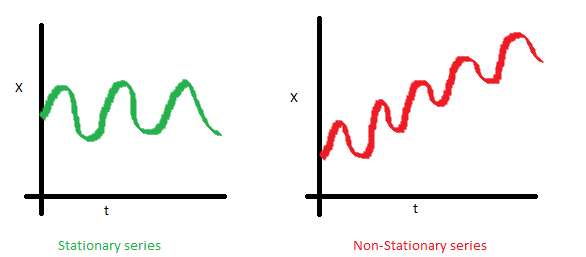

Здесь не повезло с дисперсией — разброс значений ряда существенно варьируется в зависимости от периода

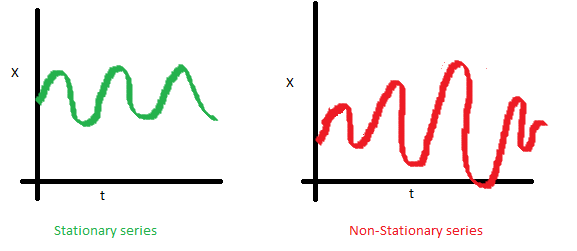

Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

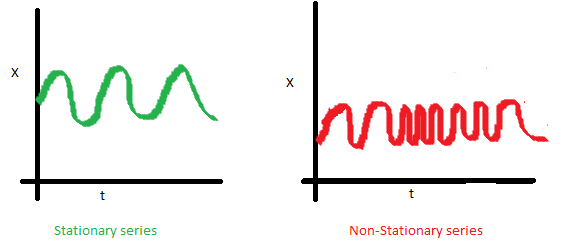

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Чтобы бороться с нестационарностью, нужно узнать её в лицо, потому посмотрим, как её детектировать. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в другое бесплатно и без смс.

График белого шума:

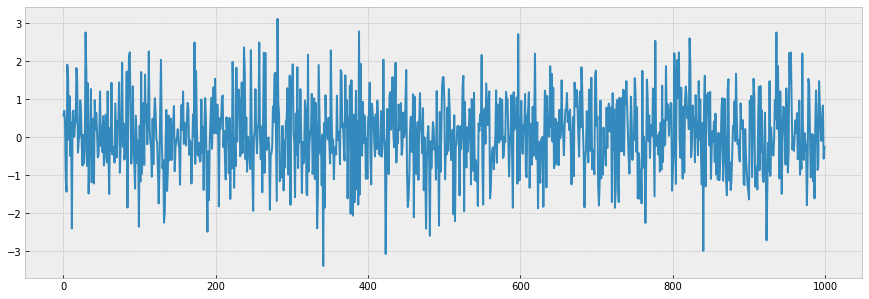

In [17]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на основании него сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$

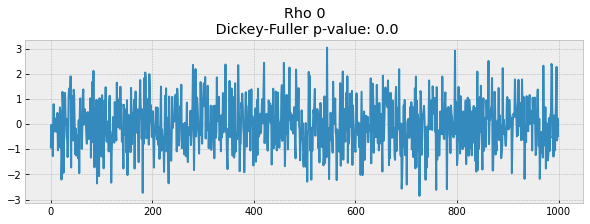

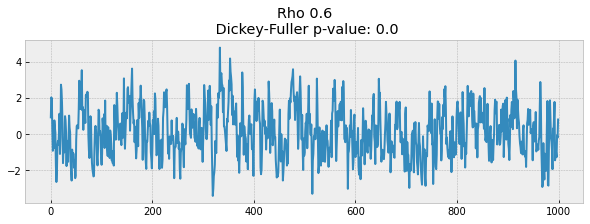

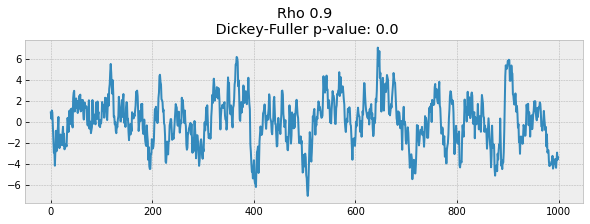

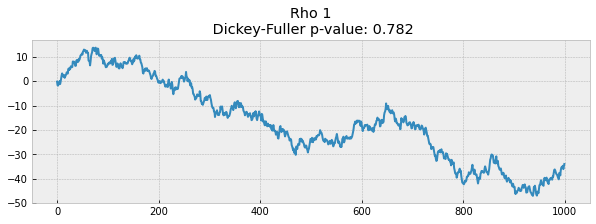

In [18]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение $\rho$ увеличилось до 0.6, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение $\rho$ равное единице дало процесс случайного блуждания — ряд не стационарен.

Происходит это из-за того, что при достижении критической единицы, ряд $x_t = \rho x_{t-1} + e_t$ перестаёт возвращаться к своему среднему значению. Если вычесть из левой и правой части $x_{t-1}$, то получим $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, где выражение слева — первые разности. Если $\rho=1$, то первые разности дадут стационарный белый шум $e_t$. Этот факт лёг в основу теста Дики-Фуллера на стационарность ряда (наличие единичного корня). Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка. Нулевая гипотеза теста — ряд не стационарен, отвергалась на первых трех графиках, и принялась на последнем. Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.

Бороться с нестационарностью можно множеством способов — разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

Избавляемся от нестационарности и строим SARIMA

Попробуем теперь построить ARIMA модель для онлайна игроков, пройдя все круги ада стадии приведения ряда к стационарному виду. Про саму модель уже не раз писали на хабре — Построение модели SARIMA с помощью Python+R, Анализ временных рядов с помощью python, поэтому подробно останавливаться на ней не буду.

Критерий Дики-Фуллера: p=0.190189


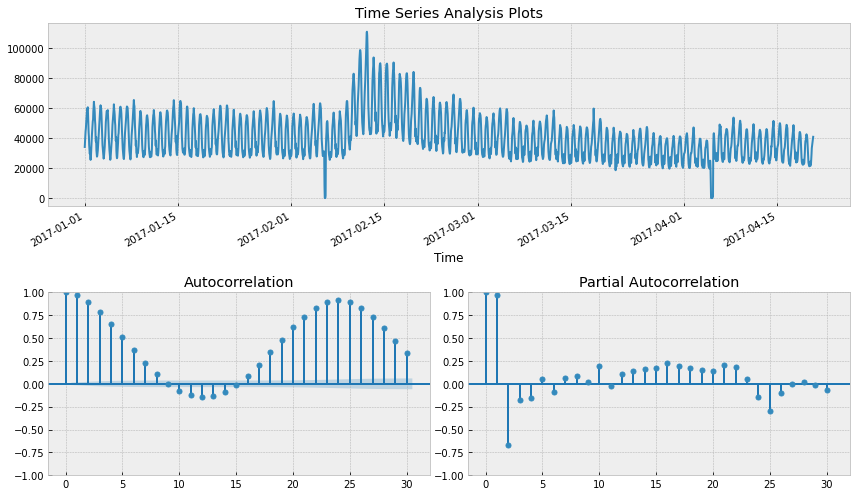

In [19]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.Users, lags=30)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

Критерий Дики-Фуллера: p=0.079760
Оптимальный параметр преобразования Бокса-Кокса: 0.587270


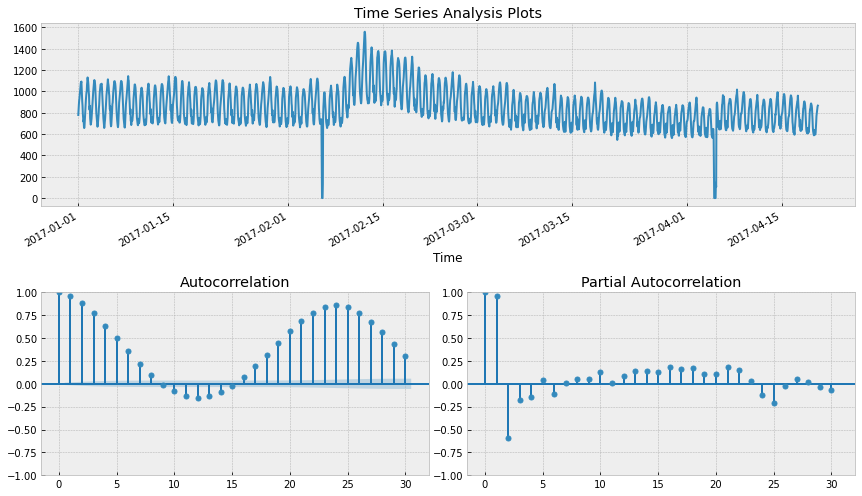

In [20]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['Users_box'], lmbda = scs.boxcox(data.Users+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Уже лучше, однако критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Критерий Дики-Фуллера: p=0.002571


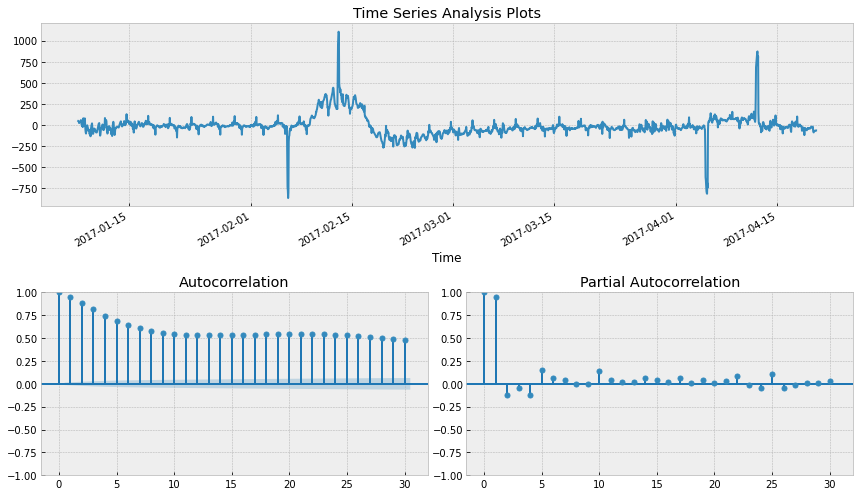

In [21]:
data['Users_box_season'] = data.Users_box - data.Users_box.shift(24*7)
tsplot(data.Users_box_season[24*7:], lags=30)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести наконец ряд к стационарному виду.

Критерий Дики-Фуллера: p=0.000000


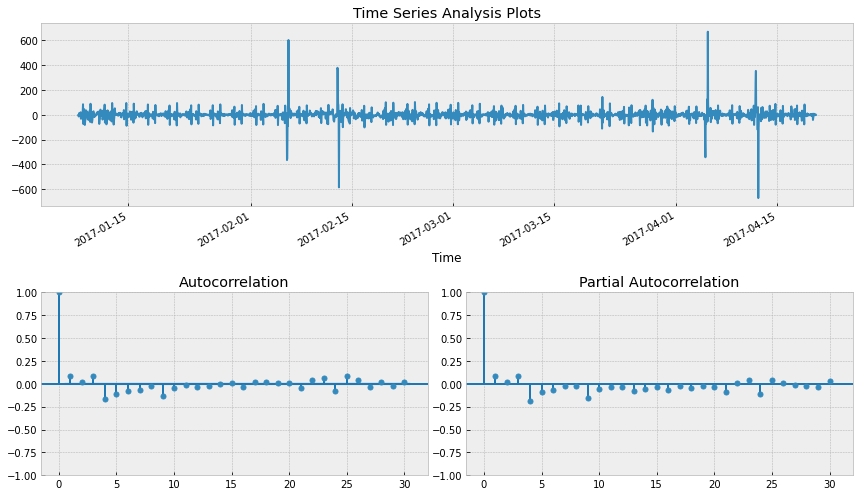

In [22]:
data['Users_box_season_diff'] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24*7+1:], lags=30)

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [23]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [ ]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Users_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/al/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/al/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

  1%|▍                                          | 1/100 [00:29<48:01, 29.11s/it]/home/al/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/al/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency inf

Лучшие параметры загоняем в модель:

In [ ]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary())                                        

Проверим остатки модели:

In [ ]:
tsplot(best_model.resid[24:], lags=30)